In [1]:
# some standard python imports #
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
import lenstronomy.Plots.output_plots as lens_plot
from lenstronomy.LightModel.light_model import LightModel
import lenstronomy.Util.param_util as param_util
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.psf import PSF
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u



def ADD(z1,z2):
    ## This is a function that computes the angular diameter distance
    ## between two redshifts z1 and z2.
    cosmo = FlatLambdaCDM(H0=70, Om0=0.316) 
    return cosmo.angular_diameter_distance_z1z2(z1,z2)

def sigma_cr(zd,zs):
    ## This function calculates the critical surface mass density at
    ## redshift zd, relative to the source redshift zs.
    const = 1.663e18*u.M_sun / u.Mpc##c^2/(4 pi G)
    return const*(ADD(0,zs)/(ADD(zd,zs)*ADD(0,zd))) ##in units Msun/Mpc^2

def gfunc(c):
    ## This is the g(c) function that is defined
    ## commonly in NFW profiles.
    a = np.log(1.+c) - (c/(1.+c))
    return 1./a

def rs_angle(zd,rs): 
    ##takes in interloper redshift, scale redius, gives you the scale redius in angular units
    Dd = ADD(0,zd)
    rs_mpc = rs*u.Mpc
    return ((1./4.848e-6)*rs_mpc)/Dd ##gives in arcsec

def alpha_s(m,rs,zd,zs):
    ##takes in subhalo mass, scale radius, interloper redshift, source redshift
    ##returns the angular deflection at scale radius
    m_msun = m*u.M_sun
    rs_mpc = rs*u.Mpc
    con = (1./np.pi)*gfunc(200.)*(1.-np.log(2))
    return m_msun/((rs_mpc**2.)*sigma_cr(zd,zs))

def k_ext(N,m,A,zd,zs,pixsize):
    ## FOR NOW THIS IS SET TO ZERO BECAUSE I CAN'T GET IT TO WORK
    m_msun = m*u.M_sun
    A_mpc2 = (pixsize**4)*(ADD(0.,zd)**2.)*A*((4.848e-6)**2.)  ##arcsec conversion
    return 0.##-(N*m_msun)/(A_mpc2*sigma_cr(zd,zs))


def xi_to_x(xi,z):
    ##takes in physical coordinates (Mpc), turns it into angular coordinates (arcsec)
    x = np.array(((xi*u.Mpc)/ADD(0.,z))/4.848e-6)
    y = x.astype(np.float)
    return y

def x_to_xi(x,z):
    ##takes in angular coordinates (arcsec), turns it into physical coordinates (Mpc)
    return ((x*4.848e-6)*ADD(0,z))/u.Mpc

def xi_to_pix(xi,z,pixsize,pixnum):
    return (xi_to_x(xi,z))/pixsize + pixnum/2.

In [28]:
## REDSHIFTS #######################################################################################
Nit = 100 ##Number of different redshifts
zds = np.linspace(0.01,0.99,Nit)
####################################################################################################



## SOURCE PROPERTIES ###############################################################################
r_sersic_source = 10.0
r_sersic_source_clumps = 0.5
N_clump = 15
clumprandx = np.random.rand(N_clump)
clumprandy = np.random.rand(N_clump)

source_scatter = 1.
beta_ras, beta_decs = [1.7],[0.3]#(r_sersic_source/10.)*(np.random.rand(Nit)-1.),(r_sersic_source/10.)*(np.random.rand(Nit)-1.)
####################################################################################################



## LENS PROPERTIES #################################################################################
theta_lens = 10.
zl = 0.2
r_theta_lens = x_to_xi(theta_lens,zl)
####################################################################################################



## IMAGE PROPERTIES ################################################################################
pixsize = 0.2
####################################################################################################



## INTERLOPER PROPERTIES ########################################################################### 
N = 60 ##Number of perturbers
M = 20 ##Averaging different realizations

disc_size = 2. ##  interlopers are randomly distributed to a disk that is this
               ##  this times bigger than the einstein radius of the lens
r2s = ((disc_size*r_theta_lens)**2.)*(np.random.rand(N,M))
rss = np.sqrt(r2s)
theta_p = 2.*np.pi*(np.random.rand(N,M))
xs = rss*np.cos(theta_p)
ys = rss*np.sin(theta_p)
xpixs = np.zeros([Nit,N,M])
ypixs = np.zeros([Nit,N,M])
####################################################################################################

    
imagesz = []
for j in range(Nit):
    
    imagesM = []
    
    xpixs[j] = xi_to_pix(xs,zds[j],pixsize,200)
    ypixs[j] = xi_to_pix(ys,zds[j],pixsize,200)
    
    for k in range(M):
        m =1.0e7#ms[j]
        if j == 0:
            m = 0.
        zs = 1.
        zd = zds[j]##0.5
        rs = 0.001
        A = 80**2 ## in arcsec
        pixsize = 0.2
        
        

        kext = float(k_ext(N,m,A,zl,zs,pixsize))
        rsang = float(rs_angle(zd,rs))
        alphars = float(alpha_s(m,rs,zd,zs))

        lens_model_list = ['SPEP','CONVERGENCE']
        for i in range(N):
            lens_model_list.append('TNFW')

        if zl >= zd:
            redshift_list = [zd]
            for i in range(N):
                redshift_list.append(zd)
            redshift_list.append(zl)
        else:
            redshift_list = [zl,zd]
            for i in range(N):
                redshift_list.append(zd)
        
        
        z_source = zs
    
        lensModel_mp = LensModel(lens_model_list=lens_model_list,
                              z_source=z_source, lens_redshift_list=redshift_list, 
                              multi_plane=True)

        e1, e2 = param_util.phi_q2_ellipticity(phi=-0.9, q=0.8)
        gamma = 2.
        
        
        e1s, e2s = param_util.phi_q2_ellipticity(phi=0.8, q=0.2)

        center_lens_x, center_lens_y = 0.,0.

        kwargs_spep = {'theta_E': theta_lens, 'e1': e1, 'e2': e2, 
                       'gamma': gamma, 'center_x': center_lens_x, 'center_y': center_lens_y}
        kwargs_conv ={'kappa_ext': kext}

        ### We populate with random SIS distribution
        kwargs_lens = [kwargs_spep,kwargs_conv]
        for i in range(N):
            center_sis_x = xi_to_x(xs[i,k],zd)
            center_sis_y = xi_to_x(ys[i,k],zd)
            
            kwargs_sis = {'Rs':rsang,'alpha_Rs':alphars,'r_trunc': rsang*200,'center_x': center_sis_x, 'center_y': center_sis_y}
            ##param_names = ['Rs', 'alpha_Rs', 'center_x', 'center_y']
            kwargs_lens.append(kwargs_sis)
        
        # image plane coordinate #
        beta_ra, beta_dec = beta_ras[0],beta_decs[0]#0.,0.#0.03425921, 0.012145

        solver = LensEquationSolver(lensModel_mp)
        theta_ra, theta_dec = solver.image_position_from_source(beta_ra, beta_dec, kwargs_lens)

        mag = lensModel_mp.magnification(theta_ra, theta_dec, kwargs_lens)
        dt = lensModel_mp.arrival_time(theta_ra, theta_dec, kwargs_lens)
        ########################################################################
        # set up the list of light models to be used #
        source_light_model_list = ['SERSIC_ELLIPSE']
        
        
        for i in range(N_clump):
            source_light_model_list.append('SERSIC')
        
        lightModel_source = LightModel(light_model_list=source_light_model_list)
        lens_light_model_list = ['SERSIC_ELLIPSE']
        lightModel_lens = LightModel(light_model_list=lens_light_model_list)
        # define the parameters #
#        kwargs_light_source = [{'amp': 1000, 'R_sersic': r_sersic_source , 'n_sersic': 1.5, 
#                                'center_x': beta_ra, 'center_y': beta_dec}]
        
        kwargs_light_source = [{'amp': 0., 'R_sersic': r_sersic_source, 'n_sersic': gamma, 
                              'e1': e1s, 'e2': e2s, 'center_x': beta_ra , 'center_y': beta_dec}]
        
        for i in range(N_clump):
            kwargs_light_source.append({'amp': 1000, 'R_sersic': r_sersic_source/30. , 'n_sersic': 1.5, 
                                'center_x': beta_ra+source_scatter*(clumprandx[i]-.5), 
                                        'center_y': beta_dec+source_scatter*(clumprandy[i]-.5)})
        
        
        kwargs_light_lens = [{'amp': 1500, 'R_sersic': theta_lens, 'n_sersic': gamma, 
                              'e1': e1, 'e2': e2, 'center_x': center_lens_x , 'center_y': center_lens_y}]

        # evaluate surface brightness at a specific position #
        flux = lightModel_lens.surface_brightness(x=1, y=1, kwargs_list=kwargs_light_lens)

        
        deltaPix = pixsize ###aLSO PIXSIze size of pixel in angular coordinates #

        # setup the keyword arguments to create the Data() class #
        ra_at_xy_0, dec_at_xy_0 = -20, -20 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
        transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
        kwargs_pixel = {'nx': 200, 'ny': 200,  # number of pixels per axis
                        'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                        'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                        'transform_pix2angle': transform_pix2angle} 
        pixel_grid = PixelGrid(**kwargs_pixel)
        # return the list of pixel coordinates #
        x_coords, y_coords = pixel_grid.pixel_coordinates
        # compute pixel value of a coordinate position #
        x_pos, y_pos = pixel_grid.map_coord2pix(ra=0, dec=0)
        # compute the coordinate value of a pixel position #
        ra_pos, dec_pos = pixel_grid.map_pix2coord(x=20, y=10)

        # import the PSF() class #
        
        kwargs_psf = {'psf_type': 'GAUSSIAN',  # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
                      'fwhm': 0.01,  # full width at half maximum of the Gaussian PSF (in angular units)
                      'pixel_size': deltaPix  # angular scale of a pixel (required for a Gaussian PSF to translate the FWHM into a pixel scale)
                     }
        psf = PSF(**kwargs_psf)
        # return the pixel kernel correspon
        kernel = psf.kernel_point_source

        ####################################################################################

        # import the ImageModel class #
        
        # define the numerics #
        kwargs_numerics = {'supersampling_factor': 1, # each pixel gets super-sampled (in each axis direction) 
                          'supersampling_convolution': False}
        # initialize the Image model class by combining the modules we created above #
        imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel_mp,
                                source_model_class=lightModel_source,
                                lens_light_model_class=lightModel_lens,
                                #point_source_class=pointSource, 
                                kwargs_numerics=kwargs_numerics)
        # simulate image with the parameters we have defined above #
        image = imageModel.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source,
                                 kwargs_lens_light=kwargs_light_lens)#, kwargs_ps=kwargs_ps)
        imagesM.append(image)
        
    imagesz.append(imagesM)
    print(j)

np.save('justclumpyimage.npy',imagesz)
np.save('justclumpyimage_XPIX.npy',xpixs)
np.save('justclumpyimage_YPIX.npy',ypixs)

0.01


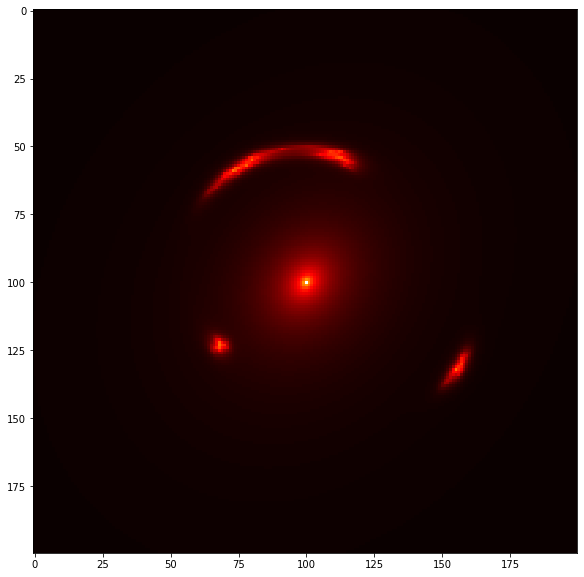

0.09909090909090908


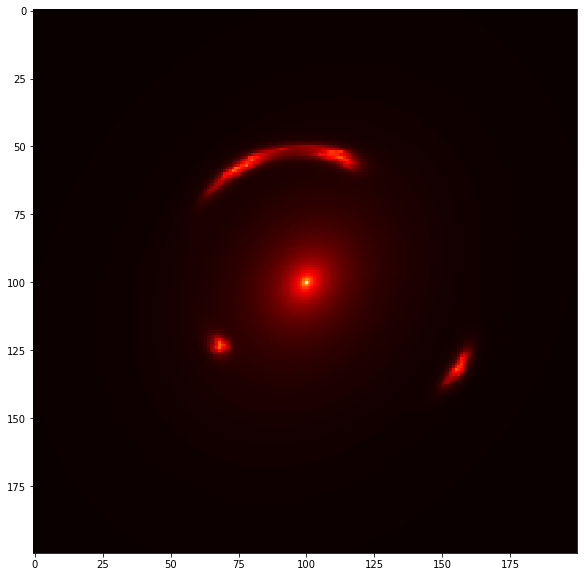

0.19808080808080808


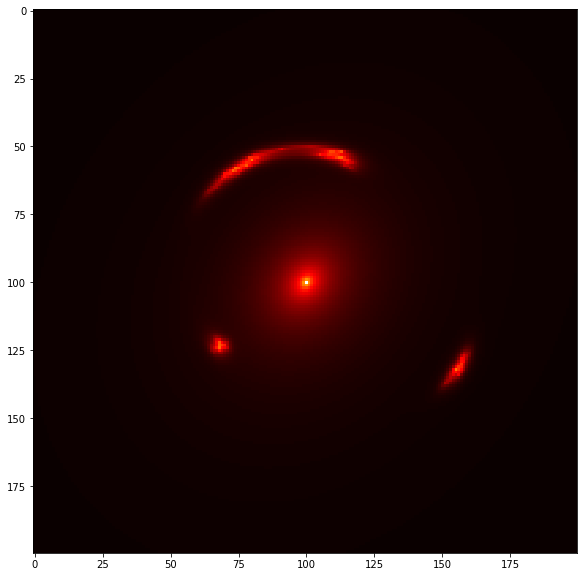

0.594040404040404


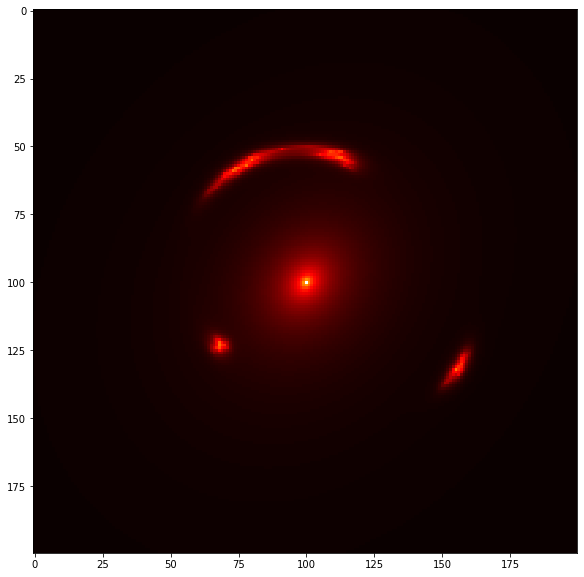

0.99


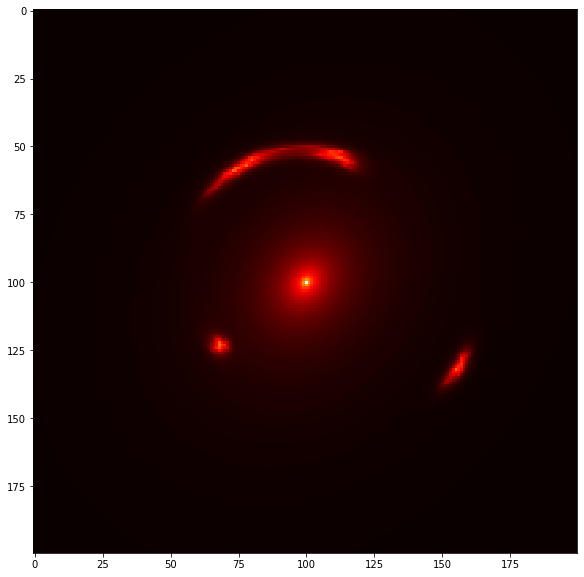

In [29]:
import matplotlib.cm as cms
##Visually examining the images
orig_cmap = cms.hot
for i in [0,9,19,59,99]:
    f, axes = plt.subplots(1, 1, figsize=(10, 10), sharex=False, sharey=False)
    axes.imshow(imagesz[i][10], cmap=orig_cmap, interpolation='nearest',vmin=0.,vmax=np.max(imagesz[0][10]))
    print(zds[i])
    plt.show()

In [30]:
### let us define a function that will create the things we need taking in a imagesz
def imstats(imagesz):
    minbin = 0.
    maxbin = 1000.
    numbin = 200
    
    
    shp = np.shape(imagesz)
    im0 = imagesz[0][0]## the first image is the massless one
    imsub = imagesz[int(shp[0]/5)]##this is the one with substructure
    
    his0,binz0, _ = pixhist(im0,minbin,maxbin,numbin)
    diffss = []
    stdss = []
    meanss = []
    sqrmeanss = []
    
    hissqrmeanses = []
    hisses = []
    for i in range(shp[0]):
        hiss = []
        hissqrmeans = []
        
        diffs = []
        stds = []
        means = []
        sqrmeans = []
        for j in range(shp[1]):
            hisa,binza, _ = pixhist(imagesz[i][j],minbin,maxbin,numbin)
            hisdiff = (hisa - his0)**2.
            hissqrmeans.append(np.mean(hisdiff))
            hiss.append(hisdiff)
            
            diff = imagesz[i][j] - im0
            stds.append(np.std(diff))
            means.append(np.mean(diff))
            sqrmeans.append(np.mean(diff**2.))
            diffs.append(diff)
            
        hisses.append(hiss)
        hissqrmeanses.append(hissqrmeans)
        
        diffss.append(diffs)
        stdss.append(stds)
        meanss.append(means)
        sqrmeanss.append(sqrmeans)
    ##stdss is the standard deviation of the residue
    ##meanss is the mean of the residue
    ##sqrmean is the square mean of the residue
    ##diffss are the residue maps
    ##hisses are the pixel value histograms
    ##hisssqrmeanses is the histogram residue mean squares
    return stdss,meanss,sqrmeanss,diffss,hisses,hissqrmeanses


def pixhist(image,minbin,maxbin,numbin):
    flatt = np.ndarray.flatten(image)
    bins = np.linspace(minbin,maxbin,numbin+1)
    his,binz = np.histogram(image,bins)
    return his,binz,flatt

In [31]:
std,mean,sqrmean,diff,hiss,hisssqr = imstats(imagesz)


sqrmeanmean = np.mean(sqrmean,axis=1)
hissmean = np.mean(hisssqr,axis=1)
meanmean = np.mean(mean,axis=1)

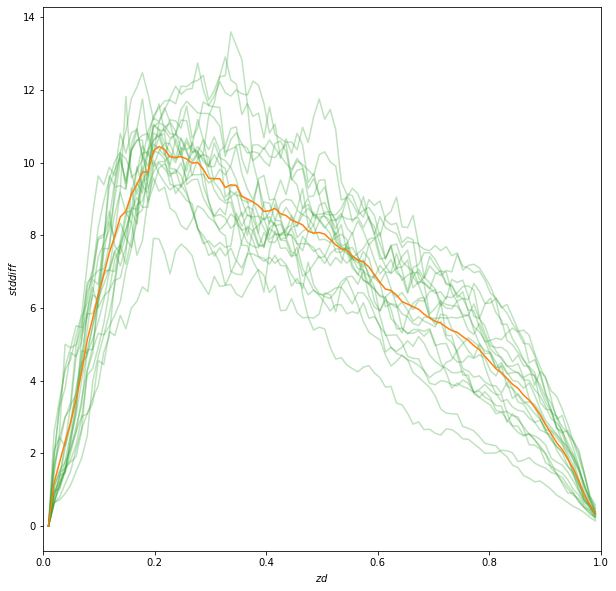

In [32]:
f, axes = plt.subplots(1, 1, figsize=(10, 10), sharex=False, sharey=False)

plt.plot(zds,hisssqr , 'C2-',alpha=0.3,label='redshift dependence')
plt.plot(zds,hissmean , 'C1-',label='redshift dependence')

plt.xlabel('$zd$')
plt.ylabel('$stddiff$')
plt.xlim(0,1)
#plt.xscale('log')
#plt.yscale('log')
#plt.legend()
plt.show()

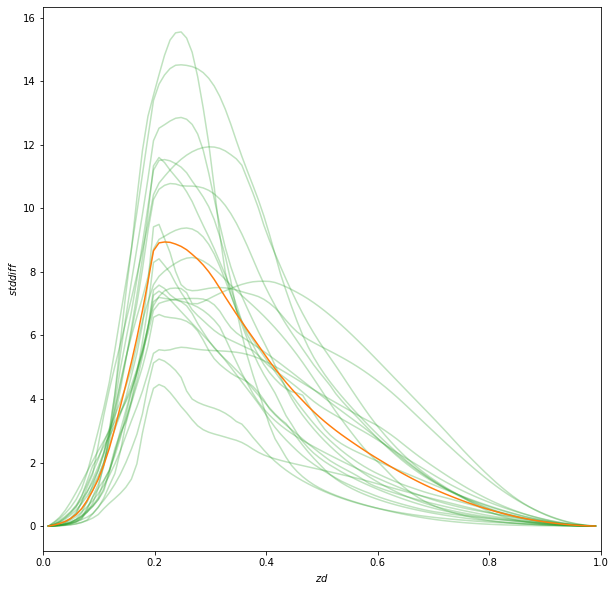

In [33]:
f, axes = plt.subplots(1, 1, figsize=(10, 10), sharex=False, sharey=False)

plt.plot(zds,sqrmean , 'C2-',alpha=0.3,label='redshift dependence')
plt.plot(zds,sqrmeanmean , 'C1-',label='redshift dependence')

plt.xlabel('$zd$')
plt.ylabel('$stddiff$')
plt.xlim(0,1)
#plt.xscale('log')
#plt.yscale('log')
#plt.legend()
plt.show()

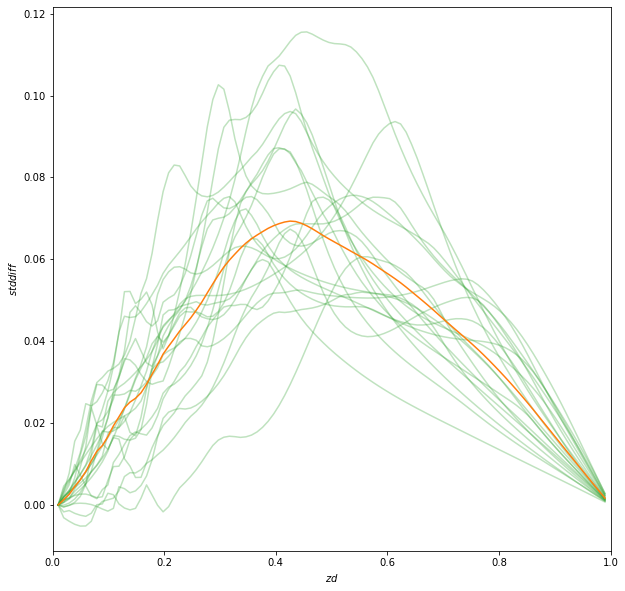

In [34]:
f, axes = plt.subplots(1, 1, figsize=(10, 10), sharex=False, sharey=False)

plt.plot(zds,mean , 'C2-',alpha=0.3,label='redshift dependence')
plt.plot(zds,meanmean , 'C1-',label='redshift dependence')

plt.xlabel('$zd$')
plt.ylabel('$stddiff$')
plt.xlim(0,1)
#plt.xscale('log')
#plt.yscale('log')
#plt.legend()
plt.show()

In [35]:
print(np.max(diff[:][10]))
print(np.min(diff[:][10]))

102.60691883903621
-54.165421568409556


0.01


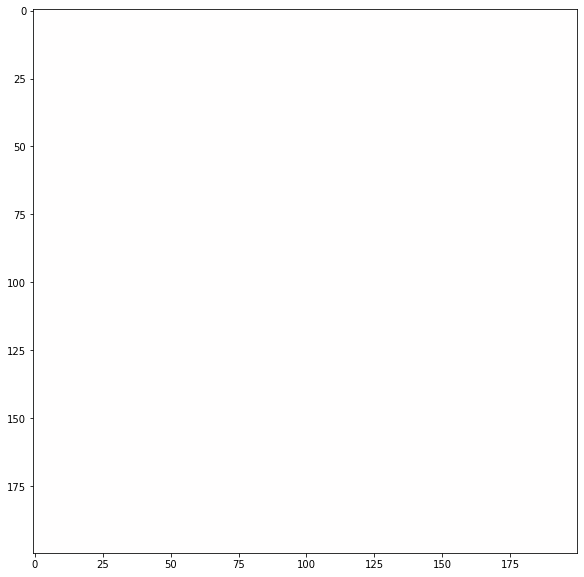

0.09909090909090908


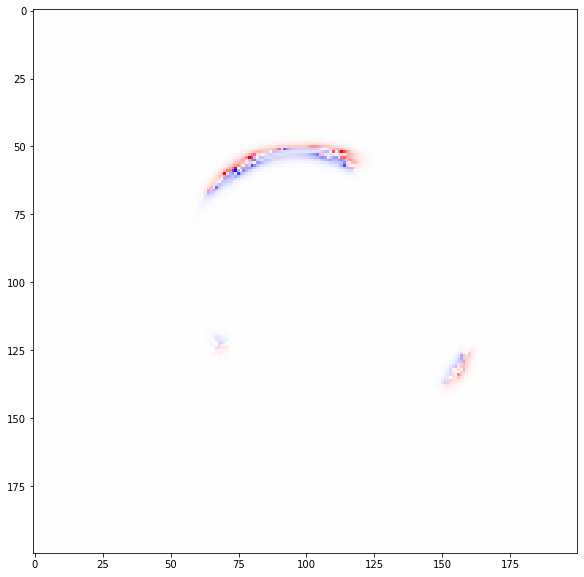

0.19808080808080808


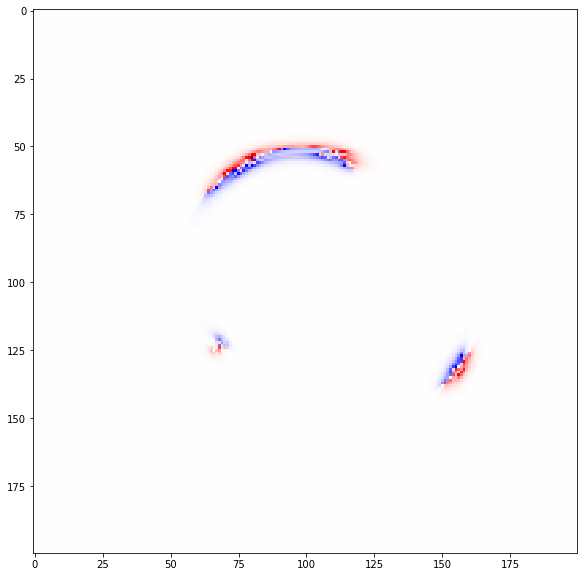

0.39606060606060606


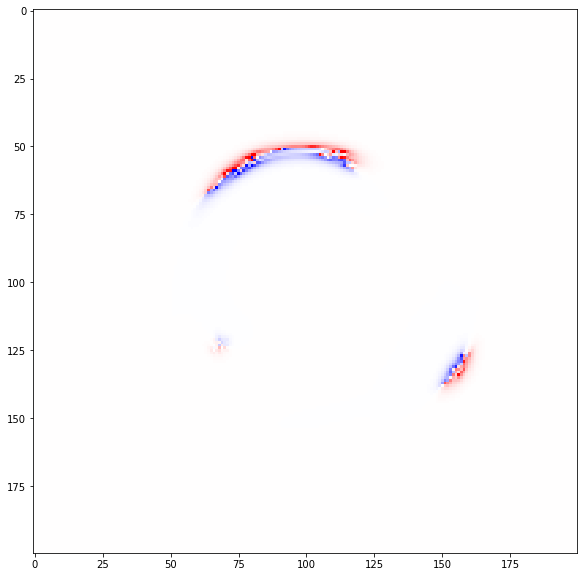

0.594040404040404


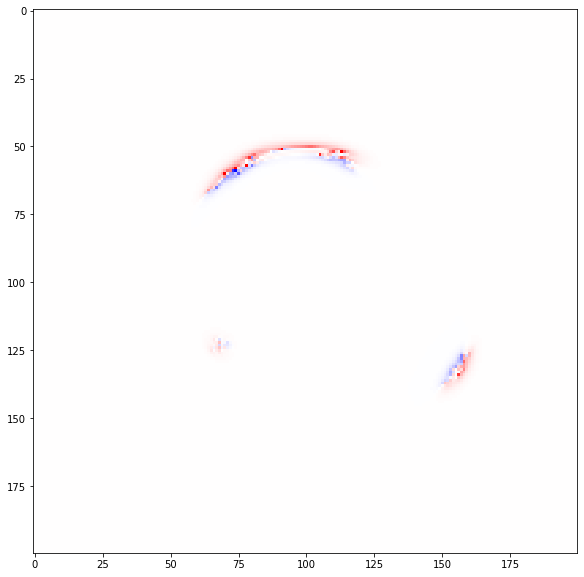

0.792020202020202


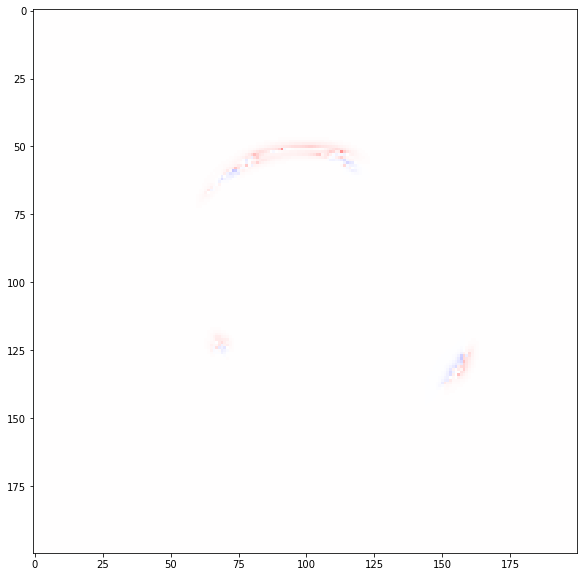

0.99


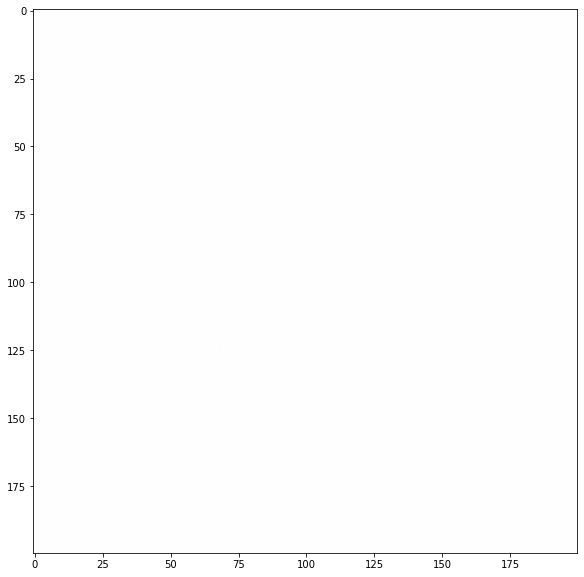

In [38]:
orig_cmap = cms.bwr
for i in [0,9,19,39,59,79,99]:
    f, axes = plt.subplots(1, 1, figsize=(10, 10), sharex=False, sharey=False)
    axes.imshow(diff[i][8], cmap=orig_cmap, interpolation='nearest',vmin=-50.,vmax=50.)
    print(zds[i])
    plt.show()

/home/cagansengul/anaconda2/envs/lensing/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


0.01


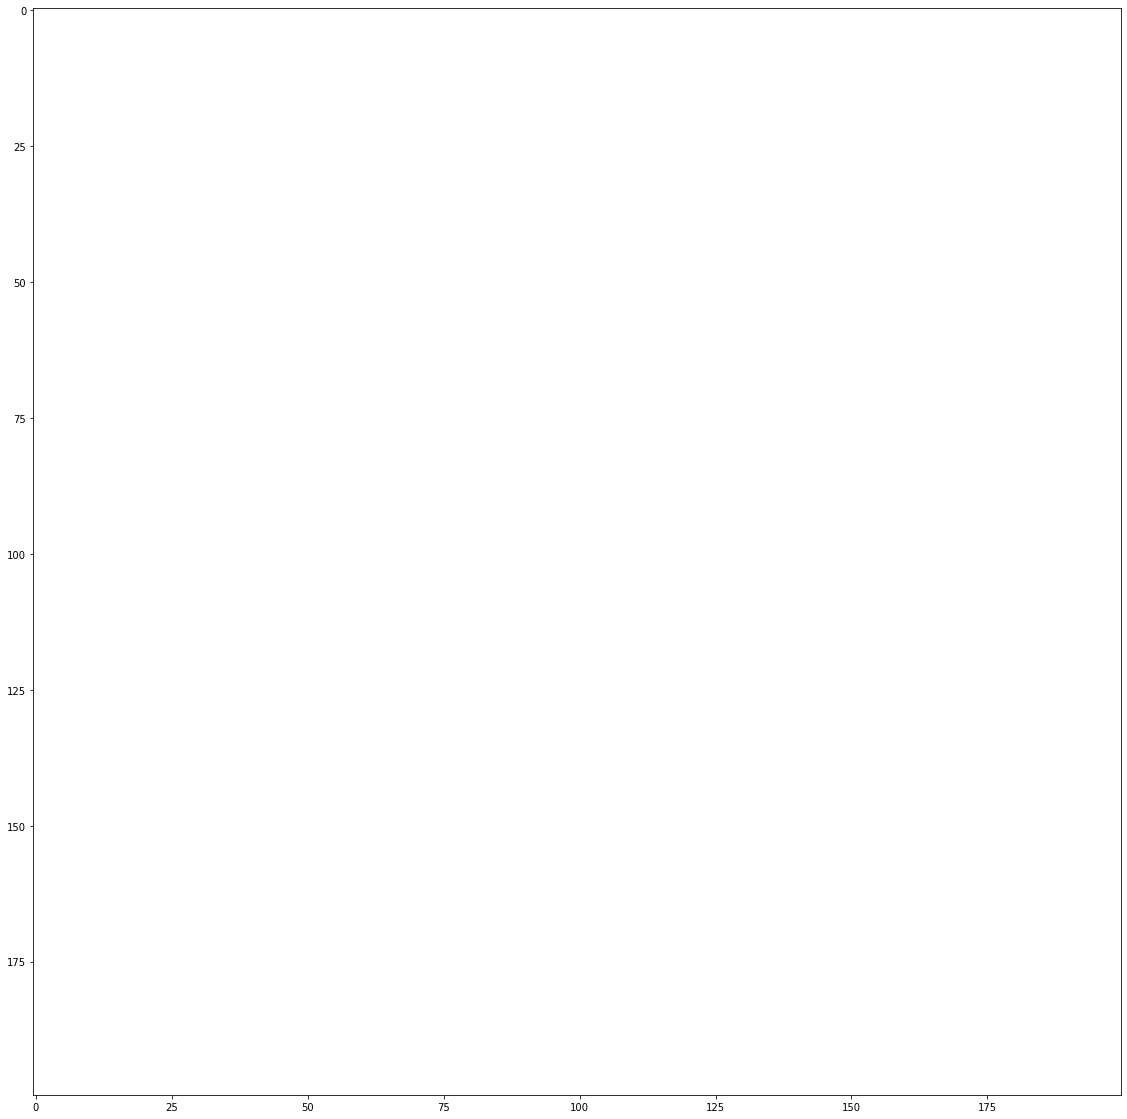

0.09909090909090908


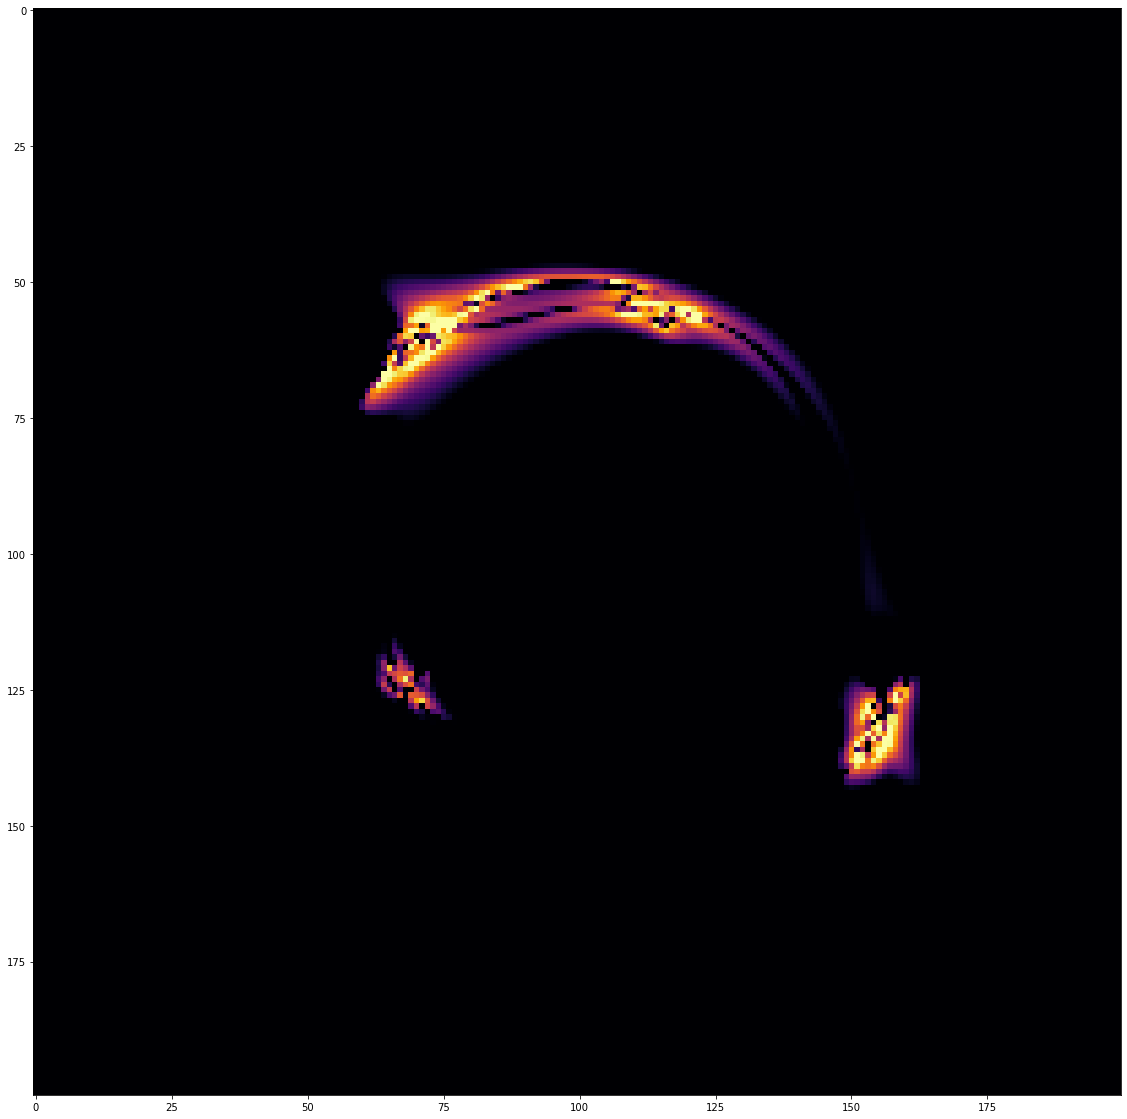

0.19808080808080808


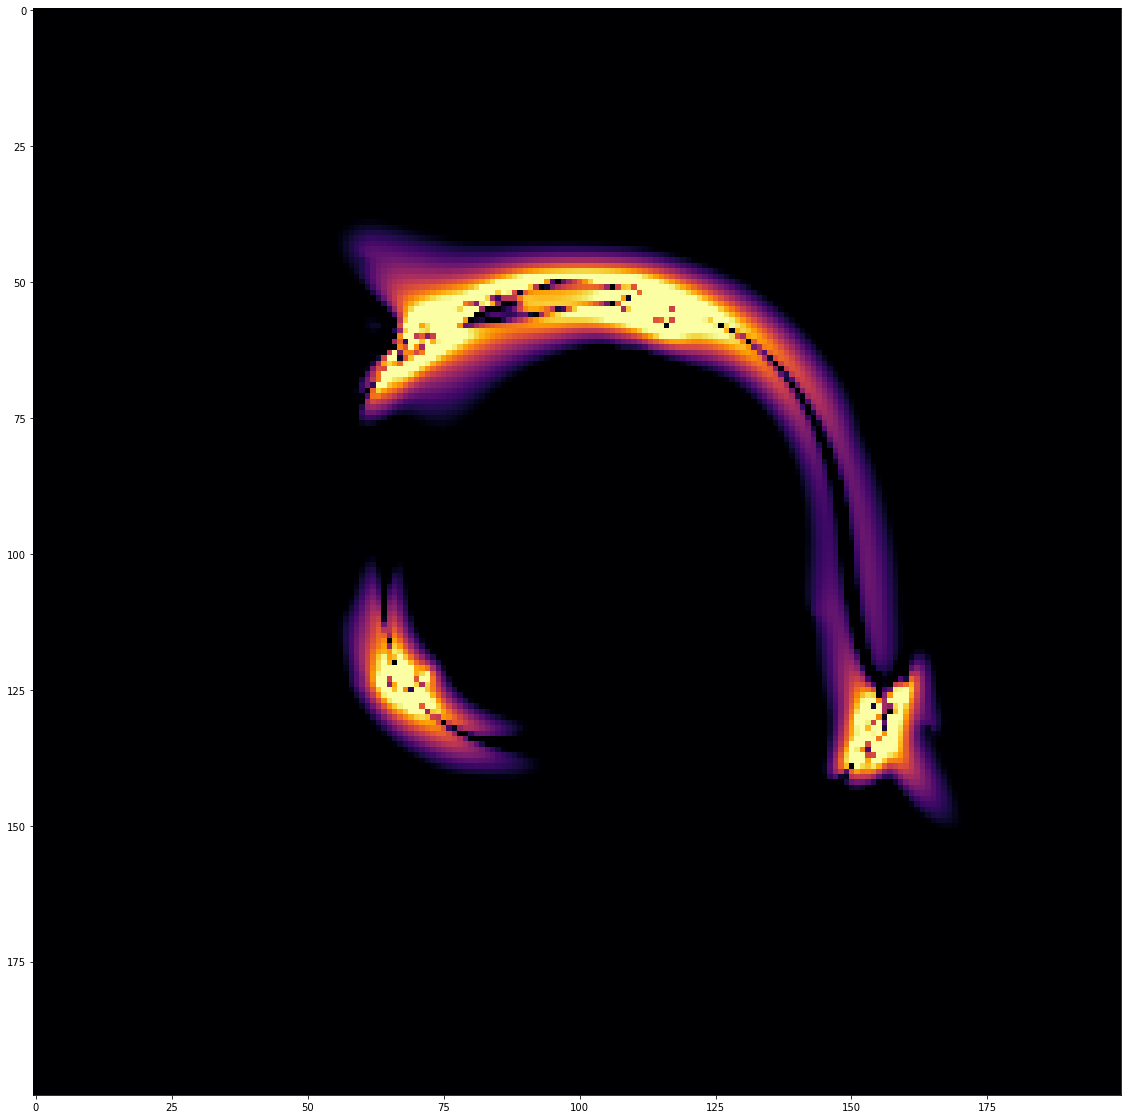

0.39606060606060606


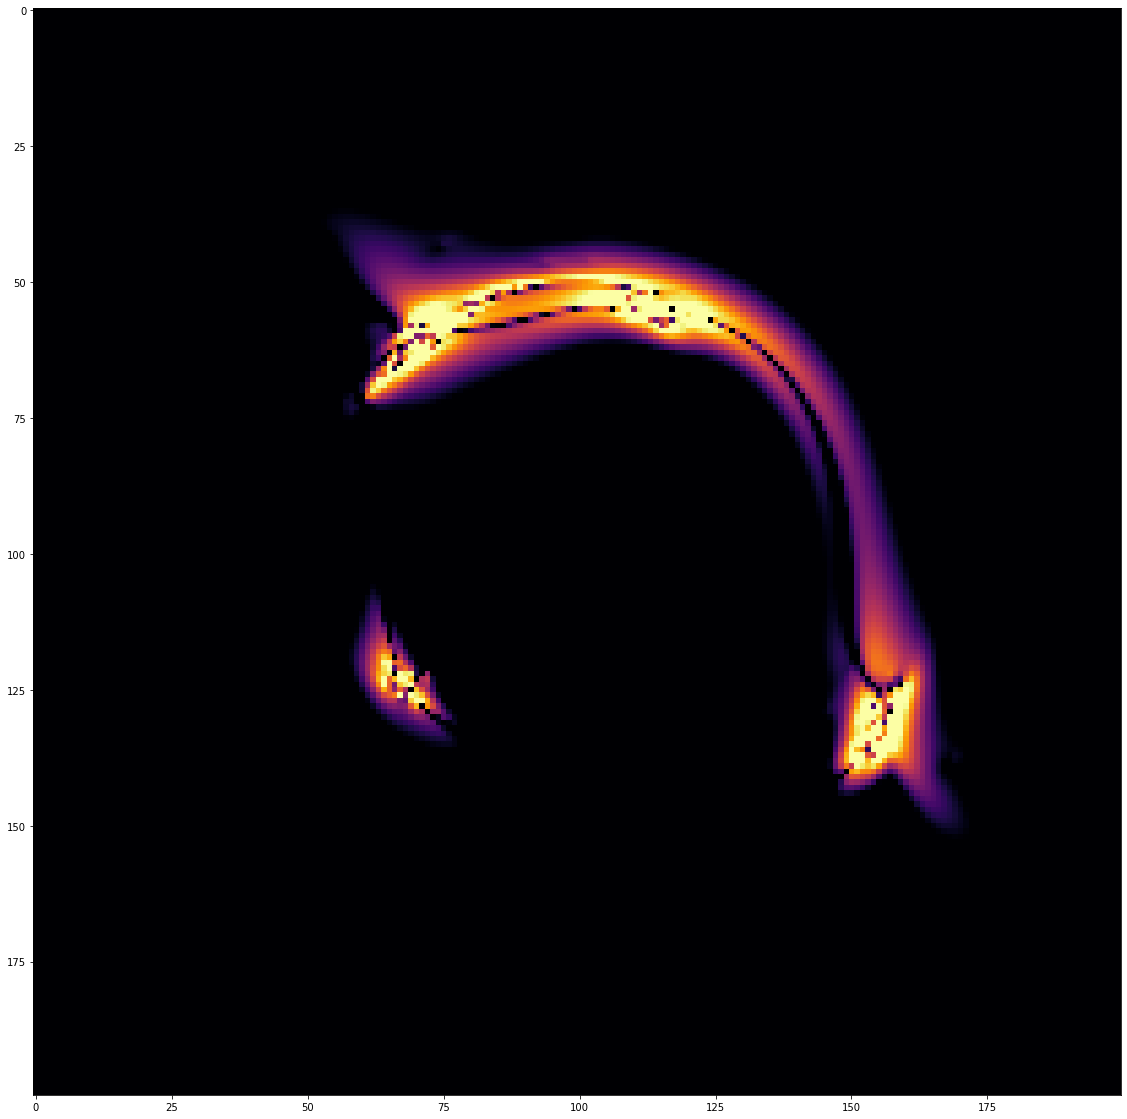

0.594040404040404


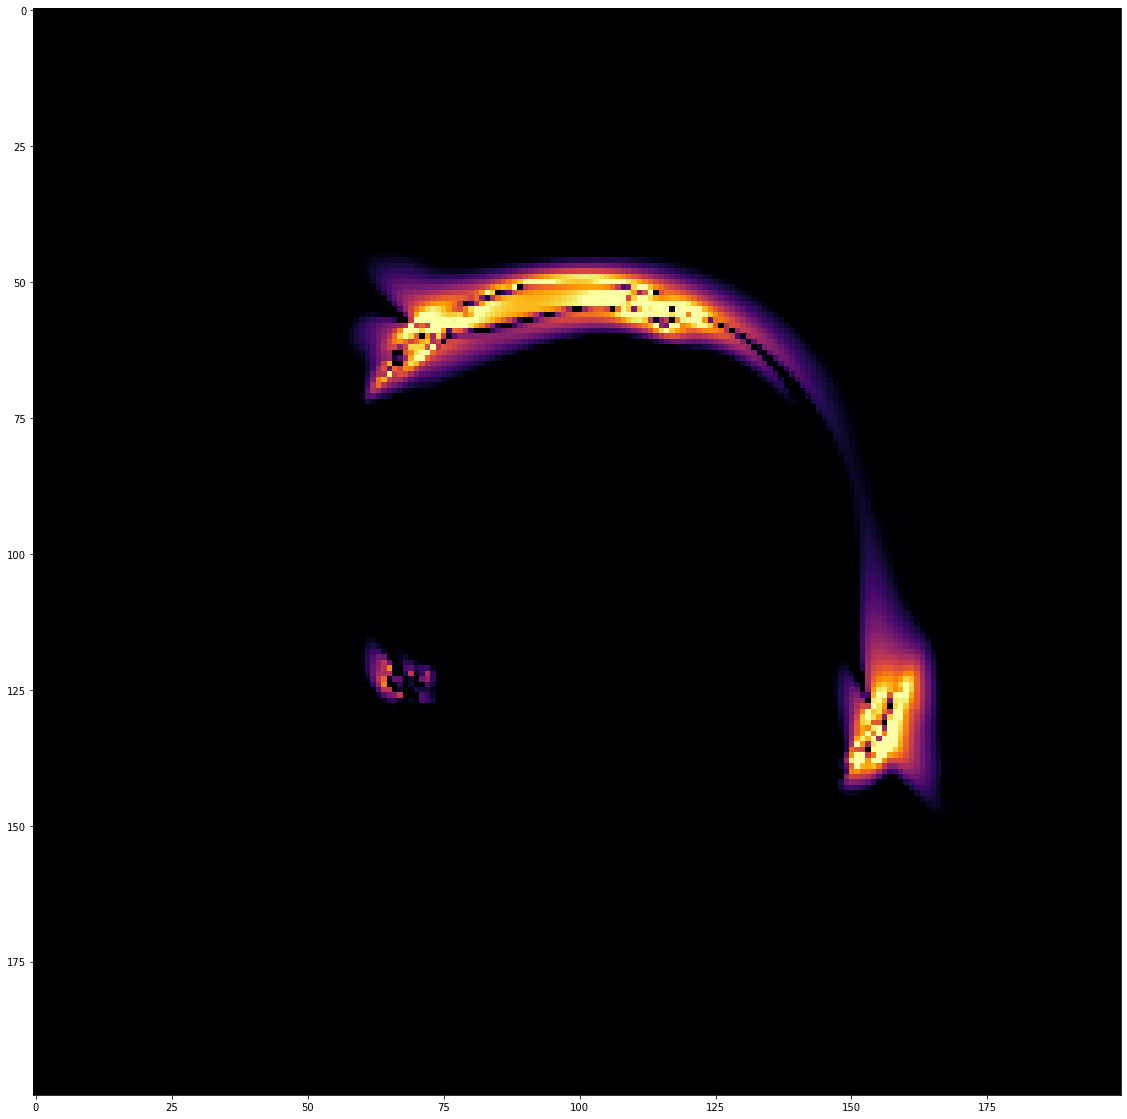

0.792020202020202


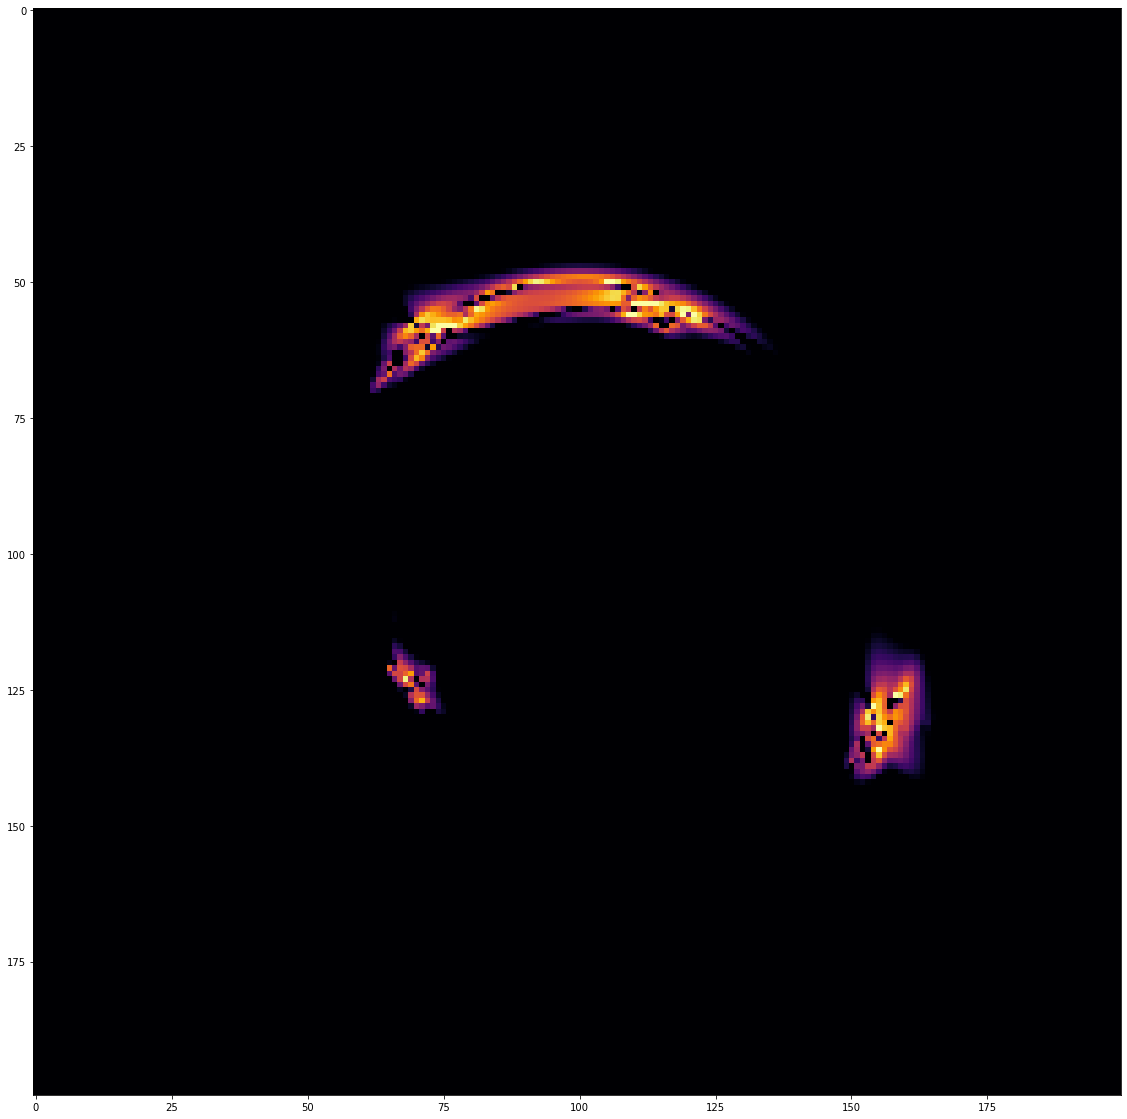

0.99


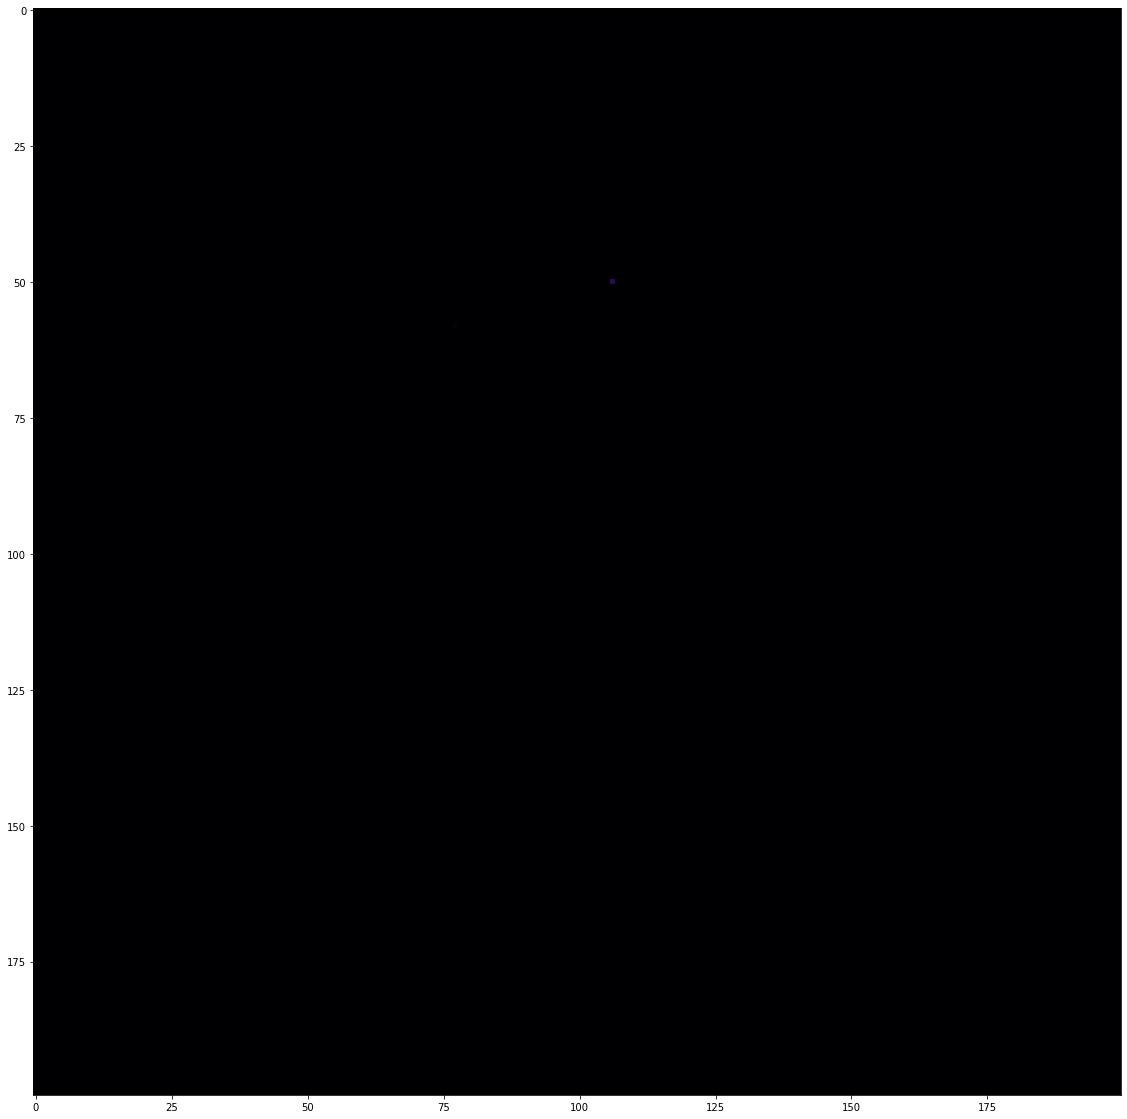

In [27]:
orig_cmap = cms.inferno
for i in [0,9,19,39,59,79,99]:
    f, axes = plt.subplots(1, 1, figsize=(20, 20), sharex=False, sharey=False)
    axes.imshow(np.log(diff[i][10]**2.), cmap=orig_cmap, interpolation='nearest',vmin=0.,vmax=5.)
    print(zds[i])
    plt.show()